7/7 [==============================] - 3s 450ms/step


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.611e-01, tolerance: 1.127e-01
  model = cd_fast.enet_coordinate_descent(


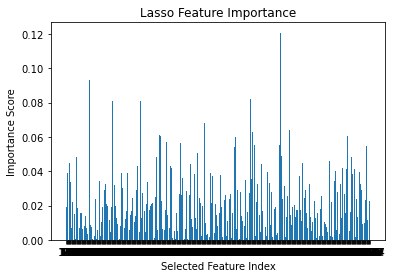

Train Accuracy: 1.00
Accuracy: 0.7819905213270142
Precision: 0.7818601150555904
Recall: 0.7819905213270142
F1-score: 0.7818914070734074
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        49
           1       0.95      0.95      0.95        43
           2       0.76      0.76      0.76        67
           3       0.74      0.75      0.74        52

    accuracy                           0.78       211
   macro avg       0.79      0.79      0.79       211
weighted avg       0.78      0.78      0.78       211



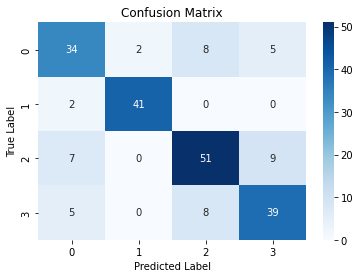

In [2]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso

# Directories for training and testing datasets
train_dir = "D:/Gokul/segall_new_exact/Train"
test_dir = "D:/Gokul/segall_new_exact/Test"

# Initialize lists for features and labels
features_cnn_train = []
labels_train = []
features_cnn_test = []
labels_test = []

# Helper function to process images
def process_images(directory, features, labels):
    categories = os.listdir(directory)
    for category in categories:
        category_path = os.path.join(directory, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (250, 250))
                img_cnn = img_to_array(img)
                features.append(img_cnn)
                labels.append(category)

# Process training and testing datasets
process_images(train_dir, features_cnn_train, labels_train)
process_images(test_dir, features_cnn_test, labels_test)

# Encode labels to numerical values
categories = list(set(labels_train))  # Unique categories
label_map = {category: idx for idx, category in enumerate(categories)}
labels_train = [label_map[label] for label in labels_train]
labels_test = [label_map[label] for label in labels_test]

# Convert features and labels to numpy arrays
features_cnn_train = np.array(features_cnn_train)
labels_train = np.array(labels_train)
features_cnn_test = np.array(features_cnn_test)
labels_test = np.array(labels_test)

# Normalize the features
features_cnn_train = features_cnn_train / 255.0
features_cnn_test = features_cnn_test / 255.0

# Create CNN model for feature extraction
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten()
])

# Extract CNN features for training and testing datasets
features_cnn_train = model_cnn.predict(features_cnn_train)
features_cnn_test = model_cnn.predict(features_cnn_test)

# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(features_cnn_train, labels_train, test_size=0.2, random_state=42)

# Normalize features (important before applying any model)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(features_cnn_test)

# Apply Lasso feature selection on the extracted features
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)  # Fit Lasso on training features and labels

# Select features based on Lasso coefficients
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Plot the importance scores of the selected features
importance_scores = np.abs(lasso.coef_)
selected_indices = selector.get_support(indices=True)

plt.bar(range(len(selected_indices)), importance_scores[selected_indices])
plt.xticks(range(len(selected_indices)), selected_indices)
plt.xlabel('Selected Feature Index')
plt.ylabel('Importance Score')
plt.title('Lasso Feature Importance')
plt.show()

# Train SVM on selected features
svc_clf = SVC(random_state=0, kernel='linear')
svc_clf.fit(X_train_selected, y_train)

# Train Accuracy
train_accuracy = svc_clf.score(X_train_selected, y_train)
print(f"Train Accuracy: {train_accuracy:.2f}")

# Predictions
y_pred = svc_clf.predict(X_test_selected)

# Metrics
accuracy = accuracy_score(labels_test, y_pred)
precision = precision_score(labels_test, y_pred, average='weighted')
recall = recall_score(labels_test, y_pred, average='weighted')
f1 = f1_score(labels_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Confusion Matrix and Classification Report
print(classification_report(labels_test, y_pred))
matrix = confusion_matrix(labels_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
